[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Stock Price with 50-day and 200-day Moving Averages'}, xlabel='Date', ylabel='Price'>

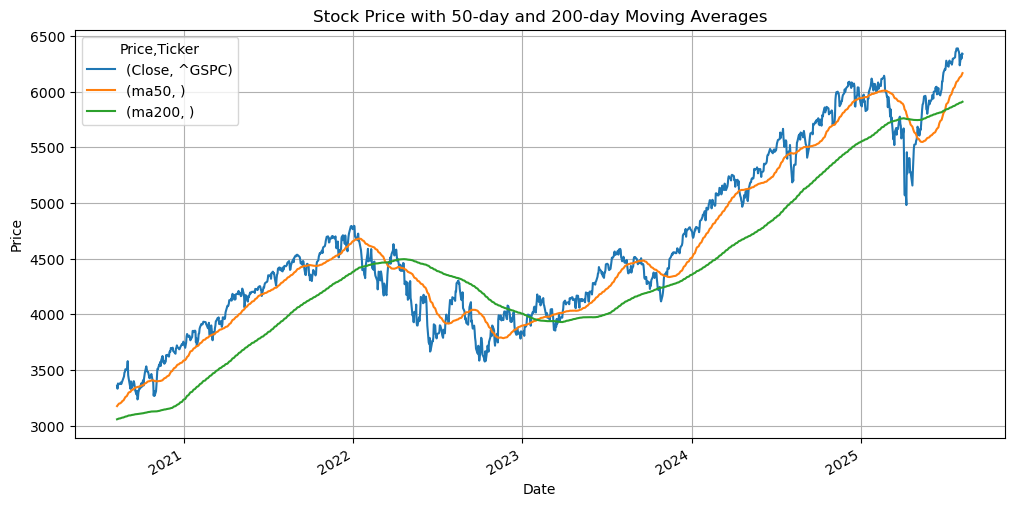

In [1062]:
#Plotting 50-day MA and 200-day MA
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

start_date = "2020-08-08"
end_date = "2025-08-08"

extended_start = pd.to_datetime(start_date) - pd.Timedelta(days = 300) 
dataF_extended = yf.download("^GSPC", start = extended_start, end = end_date, auto_adjust = True)

dataF_extended = dataF_extended.assign(
    ma50 = dataF_extended.Close.rolling(50).mean(),
    ma200 = dataF_extended.Close.rolling(200).mean()
)

dataF = dataF_extended.loc[start_date:end_date]

dataF[['Close', 'ma50', 'ma200']].plot(figsize = (12, 6), 
                                       title = "Stock Price with 50-day and 200-day Moving Averages", 
                                       ylabel = "Price", 
                                       xlabel = "Date", 
                                       grid = True)


In [1064]:
#Signalling function
def signal_generator(df):
    m50 = df.ma50.iloc[-1]
    m200 = df.ma200.iloc[-1]
    previous_m50 = df.ma50.iloc[-2]
    previous_m200 = df.ma200.iloc[-2]
    
    if (previous_m50 > previous_m200 and m200 > m50):
        return 1
    elif (previous_m50 < previous_m200 and m200 < m50):
        return 2   
    else:
        return 0

signal = []
signal.append(0)
for i in range(1,len(dataF)):
    df = dataF[i - 1:i + 1]
    signal.append(signal_generator(df))

dataF = dataF.copy()
dataF["signal"] = signal
dataF.signal.value_counts()

signal
0    1251
1       2
2       2
Name: count, dtype: int64

In [1066]:
#Backtesting
position = 0  
entry_price = 0
position_value = 0
cash = 1000  
portfolio_value = [cash] 
trades = []  

for i in range(1, len(dataF)):
    current_price = dataF.Close.iloc[i]
    current_signal = dataF.signal.iloc[i]
    

    if position == 1 and current_signal == 2: 
        pnl = float(1000 * (entry_price/current_price - 1).iloc[0])
        cash += pnl
        trades.append(('Close Short', dataF.index[i], current_price, pnl))
        position = 2
        entry_price = current_price
        trades.append(('Open Long', dataF.index[i], current_price, 0))
    elif position == 2 and current_signal == 1:  
        pnl = float(1000 * (current_price/entry_price - 1).iloc[0])
        cash += pnl
        trades.append(('Close Long', dataF.index[i], current_price, pnl))
        position = 1
        entry_price = current_price
        trades.append(('Open Short', dataF.index[i], current_price, 0))
    elif position == 0:
        if current_signal == 1: 
            position = 1
            entry_price = current_price
            cash -= 1000  
            trades.append(('Open Short', dataF.index[i], current_price, 0))
        elif current_signal == 2: 
            position = 2
            entry_price = current_price
            cash -= 1000  
            trades.append(('Open Long', dataF.index[i], current_price, 0))
    
    if position == 1:  
        position_value = 1000 * (entry_price/current_price)
    elif position == 2: 
        position_value = 1000 * (current_price/entry_price)
    else:
        position_value = 0
    
    portfolio_value.append(cash + position_value)

dataF['portfolio_value'] = portfolio_value[:len(dataF)] 

final_value = float(dataF['portfolio_value'].iloc[-1].item())
total_return = (final_value - 1000) / 1000 * 100

print(f"\nStrategy Performance Summary:")
print(f"Initial Capital: $1000")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")

dataF['portfolio_value'] = dataF['portfolio_value'].apply(
    lambda x: float(x) if np.isscalar(x) else float(x.values[0])
)

results = dataF[['Close', 'signal', 'portfolio_value']]
#results.to_csv('result.csv', index = False)


Strategy Performance Summary:
Initial Capital: $1000
Final Portfolio Value: $1186.90
Total Return: 18.69%


In [1068]:
#Additional performance metrics
results = results.copy()
results['daily_return'] = results['portfolio_value'].pct_change()

mean_ret = results['daily_return'].mean()
std_ret = results['daily_return'].std()
sharpe_ratio = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else np.nan

rolling_max = results['portfolio_value'].cummax()
drawdown = (results['portfolio_value'] - rolling_max) / rolling_max
max_drawdown = float(drawdown.min()) * 100  

closing_trades = [trade for trade in trades if trade[0].startswith('Close')]
if position != 0:
    current_price = dataF.Close.iloc[-1]
    if position == 1:  
        pnl = 1000 * (entry_price / current_price - 1).item()
        closing_trades.append(('Close Short End', dataF.index[-1], current_price, pnl))
    elif position == 2: 
        pnl = 1000 * (current_price / entry_price - 1).item()
        closing_trades.append(('Close Long End', dataF.index[-1], current_price, pnl))

wins = sum(1 for trade in closing_trades if float(trade[3]) > 0)
total_trades = len(closing_trades)
win_rate = (wins / total_trades * 100) if total_trades > 0 else 0

start_price = dataF.Close.iloc[0].item()
end_price = dataF.Close.iloc[-1].item()
buy_and_hold_return = (end_price / start_price - 1) * 100

print("\nAdditional Performance Metrics")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Number of Trades: {total_trades}")
print(f"Wins: {wins}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Buy & Hold Return: {buy_and_hold_return:.2f}%")


Additional Performance Metrics
Sharpe Ratio: 0.31
Max Drawdown: -21.06%
Number of Trades: 4
Wins: 2
Win Rate: 50.00%
Buy & Hold Return: 88.66%


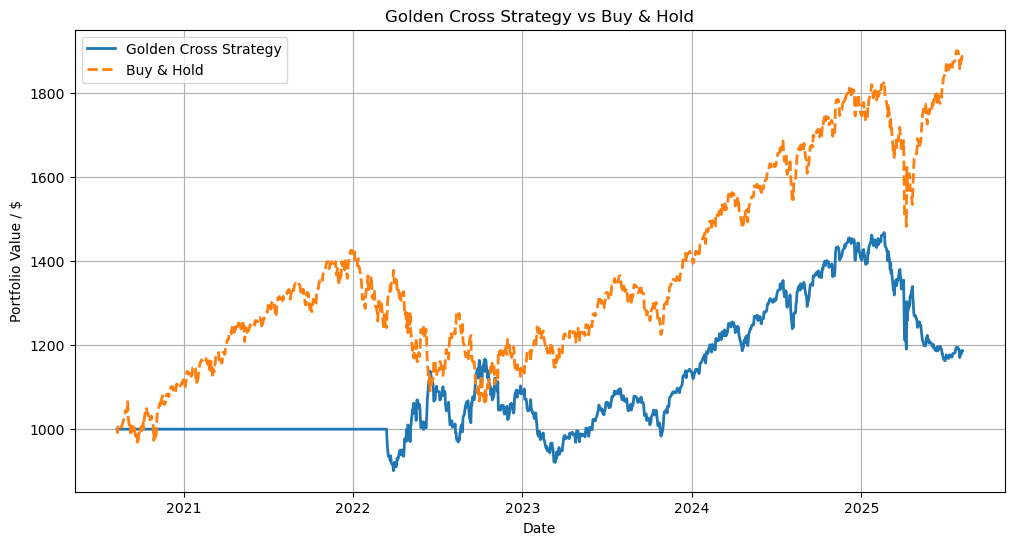

In [1070]:
#Buy and Hold vs Golden Cross Strategy
import numpy as np

initial_capital = 1000
buy_and_hold_values = initial_capital * (dataF['Close'] / dataF['Close'].iloc[0])

plt.figure(figsize = (12, 6))
plt.plot(dataF.index, dataF['portfolio_value'], label = 'Golden Cross Strategy', linewidth = 2)
plt.plot(dataF.index, buy_and_hold_values, label = 'Buy & Hold', linewidth = 2, linestyle = '--')

plt.title('Golden Cross Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value / $')
plt.grid(True)
plt.legend()
plt.show()
